# Corruption Robust NMF

## Corruption Robust Quantile Method: QMU

In [1]:
import numpy as np
import matplotlib.pylab as plt


def CorruptionRobustNMF(X, D, max_iter, r, q):
    '''
    To test QMU on matrix with no corruptions: pass in D = X\n
    (so args are X, X, max_iter, r, q)
    To test QMU on matrix with corruptions, with relative error according to
    x_corr: pass in X = D (so args are D, D, max_iter, r, q)
    '''
    #Initialize matrices
    m = D.shape[0]
    n = D.shape[1]
    W = np.abs(np.random.randn(m, r))
    H = np.abs(np.random.randn(r, n))
    errors = []

    for i in range(max_iter):
        #Construct Masking Matrix
        M = ConstructMask(D, W, H, m, n, q)

        epsilon = 10 ** -10

        #Multiplicative Updates for W, H
        W = W * (((M*D)@H.T)/(((M*(W@H))@H.T) + epsilon))
        H = H * ((W.T@(M*D))/((W.T@(M*(W@H))) + epsilon))
        errors.append(RelativeError(X, W, H))

    return W, H, M, errors


# Helper function
def ConstructMask(D, W, H, m, n, q):
    # Initialize mask
    M = np.zeros_like(D)

    # Compute k
    k = int(np.floor(m * n * (1 - q)))

    # Compute the error matrix E
    E = np.abs(D - np.dot(W, H))

    # Flatten the matrix E into an array L
    L = E.flatten()

    # Sort L in descending order
    L_sorted = np.sort(L)[::-1]

    # Get the threshold value t
    t = L_sorted[k]

    # Populate the binary mask M based on the threshold t
    for i in range(m):
        for j in range(n):
            if E[i, j] < t:
                M[i, j] = 1
            # if E[i, j] >= t:
            #     M[i, j] = 0
            # else:
            #     M[i, j] = 1

    return M


def RelativeError(X, A, S):
    error_f_norm = np.linalg.norm(X - A@S, "fro")**2
    x_norm = np.linalg.norm(X, "fro")**2

    epsilon = 10**-10
    return error_f_norm / (x_norm + epsilon)

## Adaptive QMU (AQMU)

We could call it AQUA: Adaptive Quantile Alternating Updates

In [2]:
import numpy as np
import matplotlib.pylab as plt


def AQMU(X, D, max_iter, r, q_init=0.5, lr=0.01, decay=0.99, min_lr=0.002):
    '''
    To test QMU on matrix with no corruptions: pass in D = X\n
    (so args are X, X, max_iter, r)
    To test QMU on matrix with corruptions, with relative error according to
    x_corr: pass in X = D (so args are D, D, max_iter, r, q)
    '''
    #Initialize matrices
    m = D.shape[0]
    n = D.shape[1]
    W = np.abs(np.random.randn(m, r))
    H = np.abs(np.random.randn(r, n))
    errors = []
    quantiles = []
    q = q_init

    previous_error = None  # Track previous error for gradient calculation
    previous_q = None

    for i in range(max_iter):
        #Construct Masking Matrix
        M = ConstructMask(D, W, H, m, n, q)
        M_prime = ConstructMask(D, W, H, m, n, q)

        epsilon = 10 ** -10

        #Multiplicative Updates for W, H
        W = W * (((M*D)@H.T)/(((M*(W@H))@H.T) + epsilon))
        H = H * ((W.T@(M*D))/((W.T@(M*(W@H))) + epsilon))

        # Compute the current error
        errors.append(RelativeError(X, W, H))
        quantiles.append(q)

        current_error = RelativeError(X * M, W, H)

        # Update q using gradient descent based on error change
        if previous_error is not None and previous_q is not None :
            # Calculate the "gradient" of q based on change in error
            error_gradient = (current_error - previous_error) / (q - previous_q)

            # Update q: decrease q if error is increasing, increase q if error is decreasing
            previous_q = q
            q = q - lr * error_gradient
        else:
            previous_q = q
            q = q + lr

        # Ensure q stays within a valid range [0, 1]
        q = np.clip(q, 0, 1)

        # Update previous error
        previous_error = current_error

        # Adaptive Learning Rate Adjustments
        # Decay the learning rate gradually
        lr = max(min_lr, lr * decay)

    return W, H, M, errors, quantiles


# Helper function
def ConstructMask(D, W, H, m, n, q):
    # Initialize mask
    M = np.zeros_like(D)

    # Compute k
    k = int(np.floor(m * n * (1 - q)))

    # Compute the error matrix E
    E = np.abs(D - np.dot(W, H))

    # Flatten the matrix E into an array L
    L = E.flatten()

    # Sort L in descending order
    L_sorted = np.sort(L)[::-1]

    # Get the threshold value t
    t = L_sorted[k]

    # Populate the binary mask M based on the threshold t
    for i in range(m):
        for j in range(n):
            if E[i, j] < t:
                M[i, j] = 1
            # if E[i, j] >= t:
            #     M[i, j] = 0
            # else:
            #     M[i, j] = 1

    return M


def RelativeError(X, A, S):
    error_f_norm = np.linalg.norm(X - A@S, "fro")**2
    x_norm = np.linalg.norm(X, "fro")**2

    epsilon = 10**-10
    return error_f_norm / (x_norm + epsilon)

##Differential Evolution for Q

In [3]:
from scipy import optimize
from scipy.optimize import differential_evolution


def objective_function(X, D, max_iter, r, q):
  '''
  The objective function to be optimized
  '''
  q = q[0]

  W, H, M, errors = CorruptionRobustNMF(X, D, max_iter, r, q)

  return errors[-1]

#def objective_wrapper(X,D, max_iter, r, q):
  #return objective_function(X, D, max_iter, r, q[0])


def DEQMU(X, D, max_iter, q, r=40):
  bounds = [(0, 1)] #keeps q less than 1

  result = differential_evolution(objective_function, bounds, args=(X, D, max_iter, r))
  q_opt = result.x[0]
  return q_opt



## Generate Corrupted Matrix

In [4]:
import numpy as np

def generate_factorable_matrix(m, n, k, corruption_prop=0):

    A_actual = np.abs(np.random.randint(0, high=100, size=(m,k)))
    S_actual = np.abs(np.random.randint(0, high=100, size=(k,n)))

    X = A_actual@S_actual

    # Convert X to float to allow for floating-point noise addition
    X = X.astype(float)

    X_corrupted = CorruptMatrix(X)

    return X, X_corrupted


def CorruptMatrix(X, noise_scale=1000000, q=0.1):
    m = X.shape[0]
    n = X.shape[1]
    total_elements = m * n
    num_corrupted = int(total_elements * q)

    large_noise = noise_scale * np.random.randn(num_corrupted)

    # Randomly select indices to corrupt
    corrupt_indices = np.random.choice(total_elements, size=num_corrupted, replace=False)

    # Flatten X to make it easier to index, then apply the noise
    X_flattened = X.flatten()
    X_flattened[corrupt_indices] += large_noise

    # Reshape X back to its original shape
    X_corrupted = X_flattened.reshape(m, n)

    return X_corrupted

In [5]:
import scipy.io
import numpy as np
import matplotlib.pylab as plt
import warnings
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def load_swimmer_dataset():
    mat = scipy.io.loadmat("data/Swimmer.mat")                 #load the dataset
    X_swimmer = mat['X']                                          #in this .mat file, the data is called X
    numPixels, numPics = X_swimmer.shape                          #record the number of images in the dataset, and number of pixels in each image

    pic17 = np.reshape(X_swimmer[:,17],(11,20));                  #grab the 17th image and reshape into image format
    pic170 = np.reshape(X_swimmer[:,170],(11,20));                #grab the 170th image and reshape into image format

    plt.figure(figsize=[15,6])

    plt.suptitle("Swimmer Images");
    plt.subplot(1,2,1);
    plt.imshow(pic17);                                   #display images
    plt.title("Image 17");
    plt.xticks([]);
    plt.yticks([]);

    plt.subplot(1,2,2);
    plt.imshow(pic170);
    plt.title("Image 170");
    plt.xticks([]);
    plt.yticks([]);

    return X_swimmer

## Experiments

### Plotting

In [6]:
# !sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_experiment(errors):
    plt.style.use('ggplot')
    plt.rcParams["figure.figsize"] = (19,11)
    plt.rcParams["font.size"] = 32
    # # plt.rcParams["font.weight"] = 'bold'
    plt.rcParams["xtick.color"] = 'black'
    plt.rcParams["ytick.color"] = 'black'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"] = 1
    # os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2023/bin/x86_64-linux'
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command
    # plt.rcParams['text.usetex'] = False

    plt.figure()

    LABELS = list(errors.keys())
    num_iterations = len(errors[LABELS[0]])
    COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'teal', 'yellow', 'pink']
    DASHES = [
        [1, 0],  # Solid
        [6, 2],  # Dashed
        [1, 2],  # Dotted
        [4, 2, 1, 2],  # Dash-Dot
        [8, 2, 2, 2],  # Custom
    ]
    MARKERS = ['o','d','s','*','P','H','<','8','X','v','o']
    # LENS = range(0,336)
    data = errors
    domain = range(0, num_iterations)


    for i, fname in enumerate(LABELS):
        plt.plot(domain, data[fname], label=LABELS[i], color=COLORS[i], dashes=DASHES[i], linewidth=6)#, marker=MARKERS[i], markersize=3, alpha=1.0)

    plt.xlabel("Iteration", color='black')
    # plt.ylabel(r"Relative Error $\displaystyle\frac{\norm{AS - X}}{\norm{X}})$", color='black')
    #  plt.ylabel(r"\text{Relative Error} $\displaystyle\frac{\lVert X - AS \rVert}{\lVert X \rVert}$", color='black')
    plt.xticks(ticks=np.arange(0, num_iterations, step=num_iterations//8))
    plt.grid(color='grey', linestyle='--', linewidth=.5)
    plt.legend(fancybox=True,handlelength=1.5,shadow=False,loc='upper left',ncol=1,fontsize=36, framealpha=1.0, edgecolor='black', borderpad=0.4, borderaxespad=.1)
    plt.show()

### Experiment \#1: Small Matrix

In [16]:
import numpy as np
import matplotlib.pyplot as plt

X, X_corrupted = generate_factorable_matrix(12, 10, 4, corruption_prop=0.1)

error = {}
print(error)


# _, _, _, error[r"QMU on $\displaystyle X$"] = CorruptionRobustNMF(X, X, 1000, 4, .9)
# _, _, _, error[r"QMU on $\displaystyle \tilde{X}$"] = CorruptionRobustNMF(X, X_corrupted, 1000, 4, .9)

_, _, _, error[r"QMU on "] = CorruptionRobustNMF(X, X, 1000, 4, .9)
_, _, _, error[r"QMU on$"] = CorruptionRobustNMF(X, X_corrupted, 1000, 4, .9)

# _, _, _, error["Corrupted (error vs corrupted)"] = CorruptionRobustNMF(X_corrupted, X_corrupted, 150, 10, .9)

plot_experiment(error)

{}


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp8vxuc2p6 212b39b9c89e111a5892d1f5c8efe28f.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./212b39b9c89e111a5892d1f5c8efe28f.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp8vxuc2p6/212b39b9c89e111a5892d1f5c8efe28f.log.




<Figure size 1900x1100 with 1 Axes>

In [2]:
import matplotlib.pyplot as plt

# Use LaTeX for text rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.rcParams["font.family"] = "serif"

x = range(1, 10)
y = [i**2 for i in x]

plt.plot(x, y, label=r"$y = x^2$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title(r"Plot with $\LaTeX$")
plt.legend()
plt.show()

RuntimeError: latex was not able to process the following string:
b'Plot with $\\\\LaTeX$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp5k112i_p ce44583b40534b6b45230b3a1521806e.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./ce44583b40534b6b45230b3a1521806e.tex
LaTeX2e <2024-11-01> patch level 1
L3 programming layer <2024-11-02>
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/article.cls
Document Class: article 2024/06/29 v1.4n Standard LaTeX document class
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/size10.clo)) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/type1cm/type1cm.sty) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/cm-super/type1ec.sty (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/t1cmr.fd)) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/inputenc.sty) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/geometry/geometry.sty (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/graphics/keyval.sty) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/generic/iftex/ifvtex.sty (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/generic/iftex/iftex.sty))) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/amsmath/amstext.sty (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/amsmath/amsgen.sty)) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/amsmath/amsbsy.sty) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/amsmath/amsopn.sty)) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/underscore/underscore.sty) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/firstaid/underscore-ltx.sty) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/textcomp.sty) (/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file ce44583b40534b6b45230b3a1521806e.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `\spacefactor' in math mode.
\@->\spacefactor 
                 \@m {}
l.29 {\rmfamily Plot with $\LaTeX
                                 $}%
No pages of output.
Transcript written on tmp5k112i_p/ce44583b40534b6b45230b3a1521806e.log.




<Figure size 640x480 with 1 Axes>

### Experiment \#2: Bigger Matrix

In [ ]:
X, X_corrupted = generate_factorable_matrix(120, 100, 40, corruption_prop=0.1)

error = {}
_, _, _, error[r"QMU on $\displaystyle X$"] = CorruptionRobustNMF(X, X, 400, 40, .9)
_, _, _, error[r"QMU on $\displaystyle \tilde{X}$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, .9)
# error["Corrupted (error vs corrupted)"] = CorruptionRobustNMF(X_corrupted, X_corrupted, 1000, 3, .9)

plot_experiment(error)

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp9teoo5wx 212b39b9c89e111a5892d1f5c8efe28f.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./212b39b9c89e111a5892d1f5c8efe28f.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp9teoo5wx/212b39b9c89e111a5892d1f5c8efe28f.log.




<Figure size 1900x1100 with 1 Axes>

### Experiment \#3: Swimmer Dataset

In [ ]:


X_Swimmer = load_swimmer_dataset()
X_Swimmer = X_Swimmer.astype(float, copy=False)
X_Swimmer_Corrupted = CorruptMatrix(X_Swimmer)

error = {}
_, _, _, error[r"QMU on $\displaystyle X$"] = CorruptionRobustNMF(X_Swimmer, X_Swimmer, 150, 10, 1)
_, _, _, error[r"QMU on $\displaystyle \tilde{X}$"] = CorruptionRobustNMF(X_Swimmer, X_Swimmer_Corrupted, 150, 10, .9)
# error["Corrupted (error vs corrupted)"] = CorruptionRobustNMF(X_corrupted, X_corrupted, 1000, 3, .9)

plot_experiment(error)

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpcbfq4oga b3c75251ec5aa0d520718595a488ee20.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./b3c75251ec5aa0d520718595a488ee20.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpcbfq4oga/b3c75251ec5aa0d520718595a488ee20.log.




<Figure size 1500x600 with 2 Axes>

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp068e_lj7 212b39b9c89e111a5892d1f5c8efe28f.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./212b39b9c89e111a5892d1f5c8efe28f.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp068e_lj7/212b39b9c89e111a5892d1f5c8efe28f.log.




<Figure size 1900x1100 with 1 Axes>

### Experiment \#4: Different Guesses for $q$

In [ ]:
X, X_corrupted = generate_factorable_matrix(120, 100, 40, corruption_prop=0.1)

error = {}
# _, _, _, error[r"QMU on $\displaystyle X$"] = CorruptionRobustNMF(X, X, 400, 40, .9)
# _, _, _, error[r"QMU on $\displaystyle \tilde{X} with q = 1.0$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, 1.0)
# _, _, _, error[r"QMU on $\displaystyle \tilde{X} with q = 0.95$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, .95)
_, _, _, error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.90$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, .9)
_, _, _, error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.80$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, .8)
_, _, _, error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.70$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, .7)
_, _, _, error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.50$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, .5)
# _, _, _, error[r"QMU on $\displaystyle \tilde{X} with q = 0.25$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, .25)
# _, _, _, error[r"QMU on $\displaystyle \tilde{X} with q = 0.01$"] = CorruptionRobustNMF(X, X_corrupted, 400, 40, 0.01)



# error["Corrupted (error vs corrupted)"] = CorruptionRobustNMF(X_corrupted, X_corrupted, 1000, 3, .9)

plot_experiment(error)

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpxwkf43k8 212b39b9c89e111a5892d1f5c8efe28f.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./212b39b9c89e111a5892d1f5c8efe28f.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-02-20>
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/Users/tylerheadley/Library/TinyTeX/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpxwkf43k8/212b39b9c89e111a5892d1f5c8efe28f.log.




<Figure size 1900x1100 with 1 Axes>

### Experiment \#5: AQMU

In [ ]:
X, X_corrupted = generate_factorable_matrix(120, 100, 40, corruption_prop=0.1)

error = {}
quantiles = {}
_, _, _, error[r"AQMU on $\displaystyle \tilde{X}$ with $\displaystyle q_0 = 0.50$"], quantiles[r"AQMU on $\displaystyle \tilde{X}$ with $\displaystyle q_0 = 0.50$"] = AQMU(X, X_corrupted, 400, 40, q_init=0.5)
# _, _, _, error[r"AQMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 1.0$"], quantiles = AQMU(X, X_corrupted, 400, 40, q_init=1.0)
# _, _, _, error[r"AQMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.90$"], quantiles = AQMU(X, X_corrupted, 400, 40, q_init=0.75)
# _, _, _, error[r"AQMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.01$"], quantiles = AQMU(X, X_corrupted, 400, 40, q_init=0.01)

plot_experiment(error)
plot_experiment(quantiles)


IndexError: index 12000 is out of bounds for axis 0 with size 12000

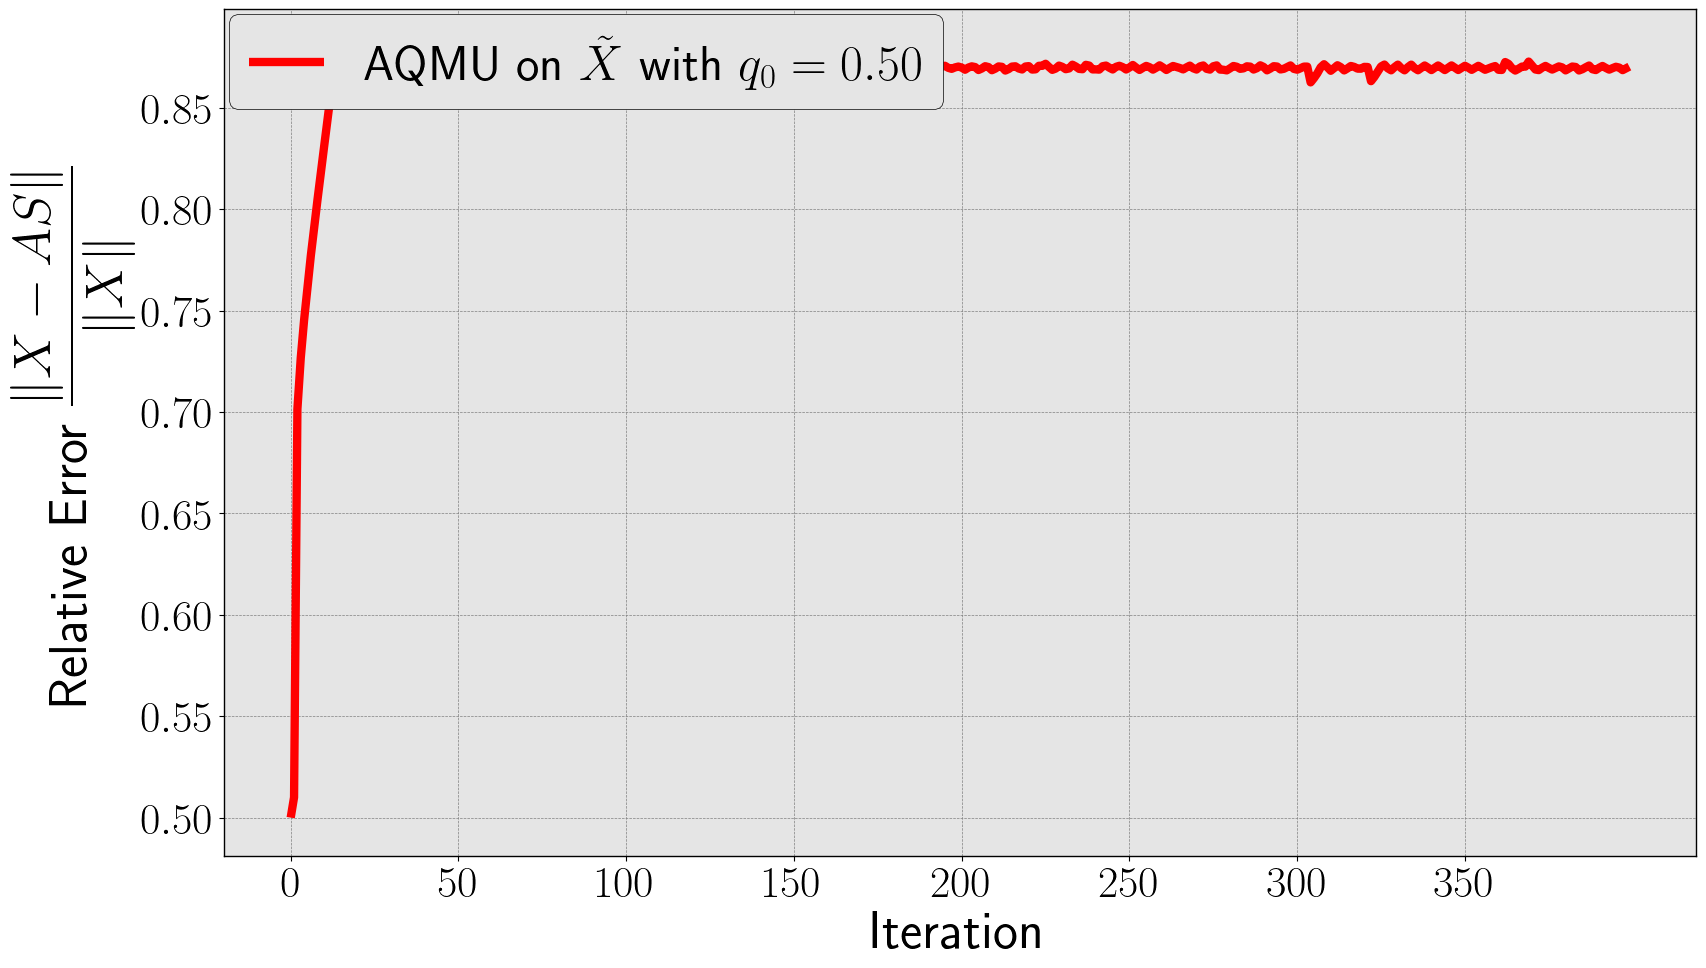

In [ ]:
plot_experiment(quantiles)

### Experiment \#6: Differential Evolution on Q

In [ ]:
X, X_corrupted = generate_factorable_matrix(12, 10, 4, corruption_prop=0.1)

print(DEQMU(X, X_corrupted, 1000, 0.5))



RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

## Plotting Multiple Runs

In [ ]:
def plot_experiment_multiple_runs(errors):
    plt.style.use('ggplot')
    plt.rcParams["figure.figsize"] = (19, 11)
    plt.rcParams["font.size"] = 32
    plt.rcParams["xtick.color"] = 'black'
    plt.rcParams["ytick.color"] = 'black'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # for \text command

    LABELS = list(errors.keys())
    num_iterations = errors[LABELS[0]].shape[1]
    domain = range(num_iterations)
    DASHES = [
        [1, 0],  # Solid
        [6, 2],  # Dashed
        [1, 2],  # Dotted
        [4, 2, 1, 2],  # Dash-Dot
        [8, 2, 2, 2],  # Custom
    ]
    COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'teal', 'yellow', 'pink']

    plt.figure()

    for i, label in enumerate(LABELS):
        data_matrix = errors[label]

        # Calculate the mean, min, and max for each iteration across different runs
        mean_error = np.mean(data_matrix, axis=0)
        min_error = np.min(data_matrix, axis=0)
        max_error = np.max(data_matrix, axis=0)

        # Plot the mean error line
        plt.plot(domain, mean_error, label=label, color=COLORS[i], dashes=DASHES[i], linewidth=3)

        # Fill between min and max for error region
        plt.fill_between(domain, min_error, max_error, color=COLORS[i], alpha=0.2)

    plt.xlabel("Iteration", color='black')
    plt.ylabel(r"\text{Relative Error} $\displaystyle\frac{\lVert X - AS \rVert}{\lVert X \rVert}$", color='black')
    plt.xticks(ticks=np.arange(0, num_iterations, step=max(1, num_iterations // 8)))
    plt.grid(color='grey', linestyle='--', linewidth=.5)
    plt.legend(fancybox=True, handlelength=1.5, shadow=False, loc='upper right', ncol=1, fontsize=36, framealpha=1.0, edgecolor='black', borderpad=0.4, borderaxespad=.1)
    plt.show()

### Small Matrix

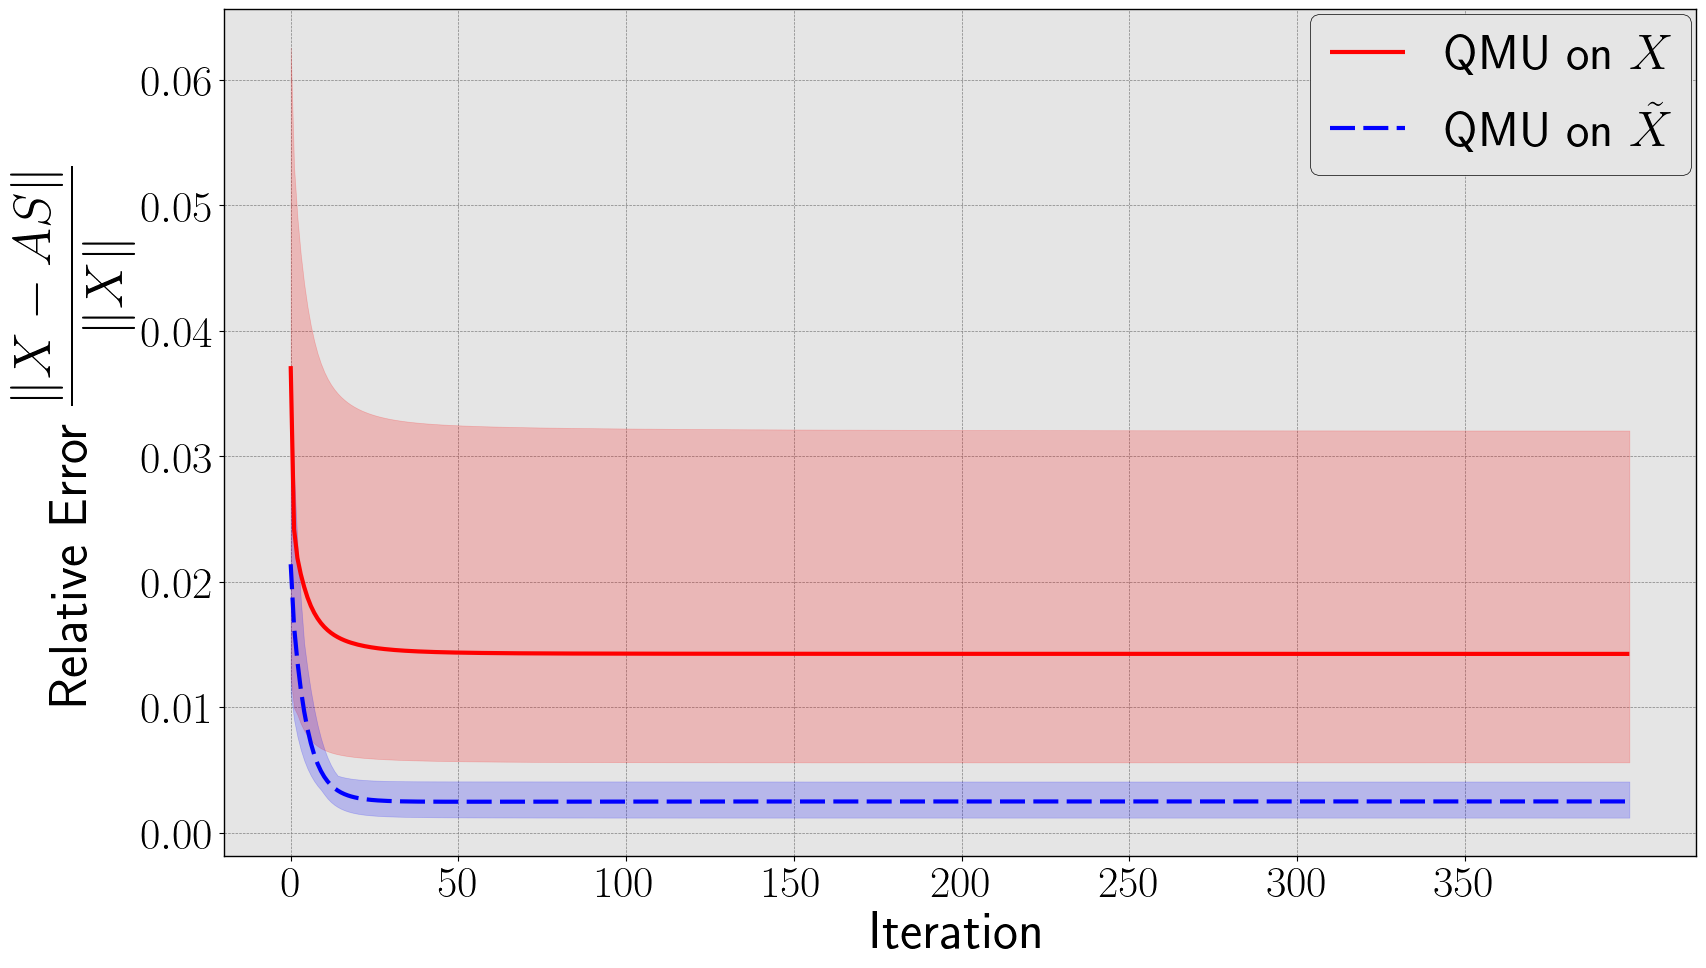

In [ ]:
error = {}
num_runs = 10  # Number of experimental runs
num_iterations = 400  # Assuming 400 iterations for each run (set this to match the actual number of iterations in errors)
error[r"QMU on $\displaystyle X$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$"] = np.zeros((num_runs, num_iterations))

for i in range(num_runs):
    X, X_corrupted = generate_factorable_matrix(12, 10, 4, corruption_prop=0.1)

    _, _, _, errors = CorruptionRobustNMF(X, X, num_iterations, 40, .9)
    error[r"QMU on $\displaystyle X$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 40, .9)
    error[r"QMU on $\displaystyle \tilde{X}$"][i, :] = errors

plot_experiment_multiple_runs(error)

### Bigger Matrix

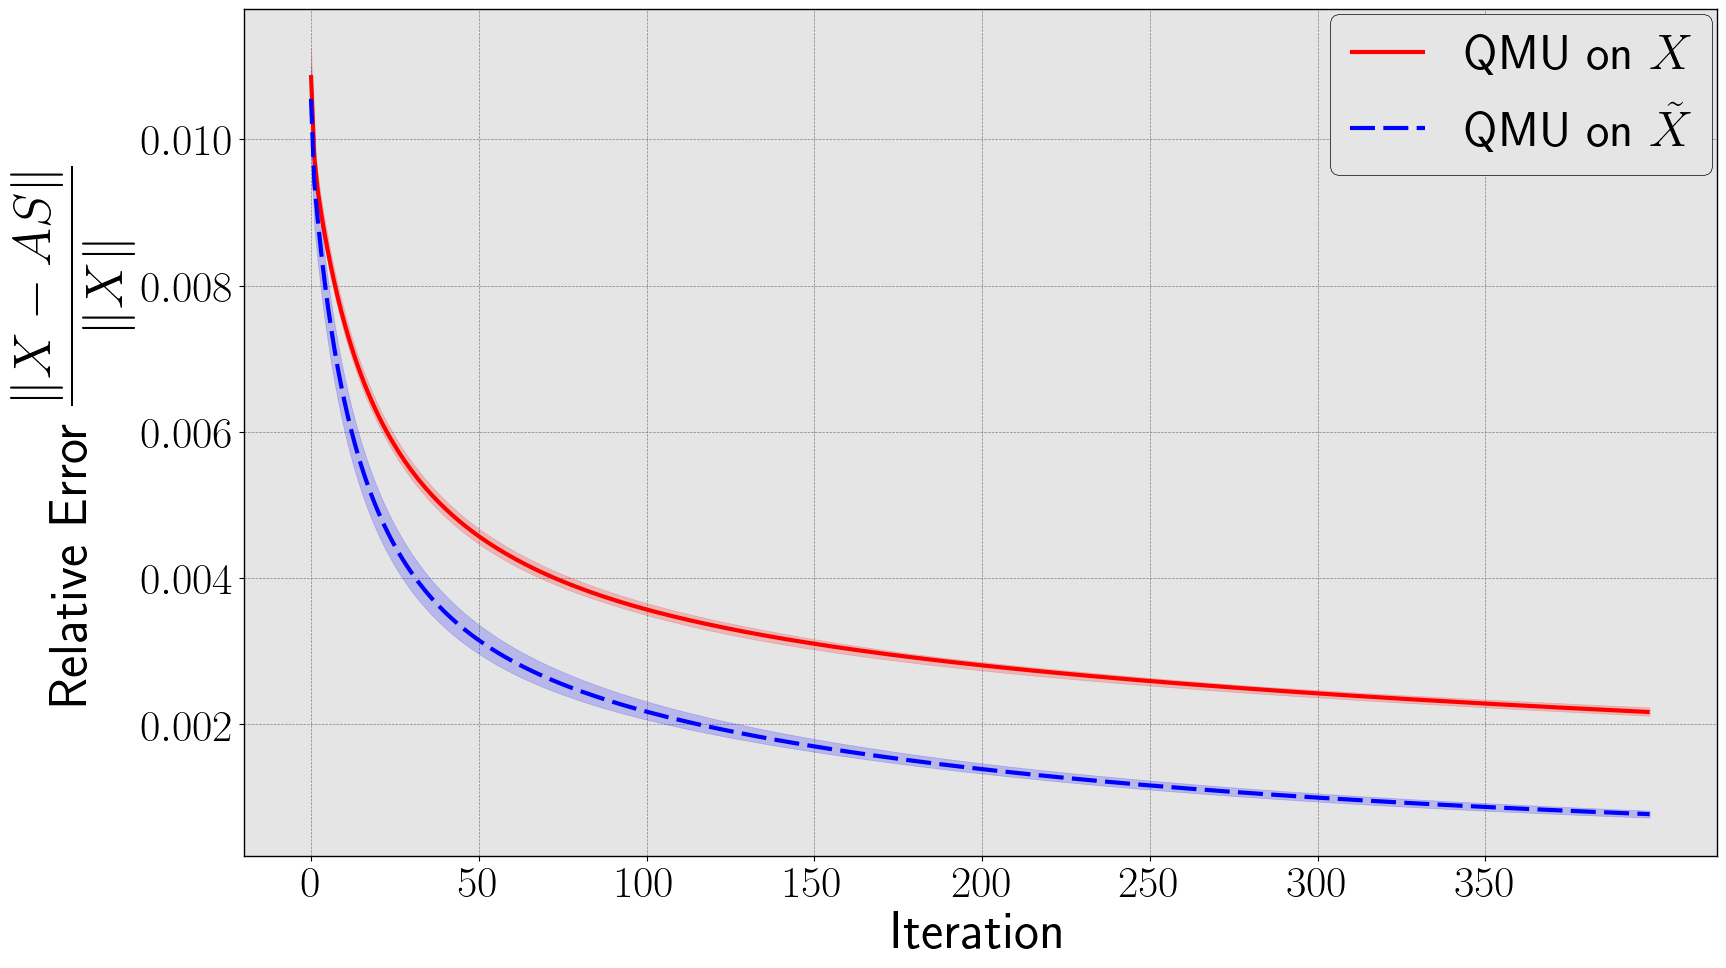

In [ ]:
error = {}
num_runs = 10  # Number of experimental runs
num_iterations = 400  # Assuming 400 iterations for each run (set this to match the actual number of iterations in errors)
error[r"QMU on $\displaystyle X$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$"] = np.zeros((num_runs, num_iterations))

for i in range(num_runs):
    X, X_corrupted = generate_factorable_matrix(120, 100, 40, corruption_prop=0.1)

    _, _, _, errors = CorruptionRobustNMF(X, X, num_iterations, 40, .9)
    error[r"QMU on $\displaystyle X$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 40, .9)
    error[r"QMU on $\displaystyle \tilde{X}$"][i, :] = errors

plot_experiment_multiple_runs(error)

### Different Guesses for $q$

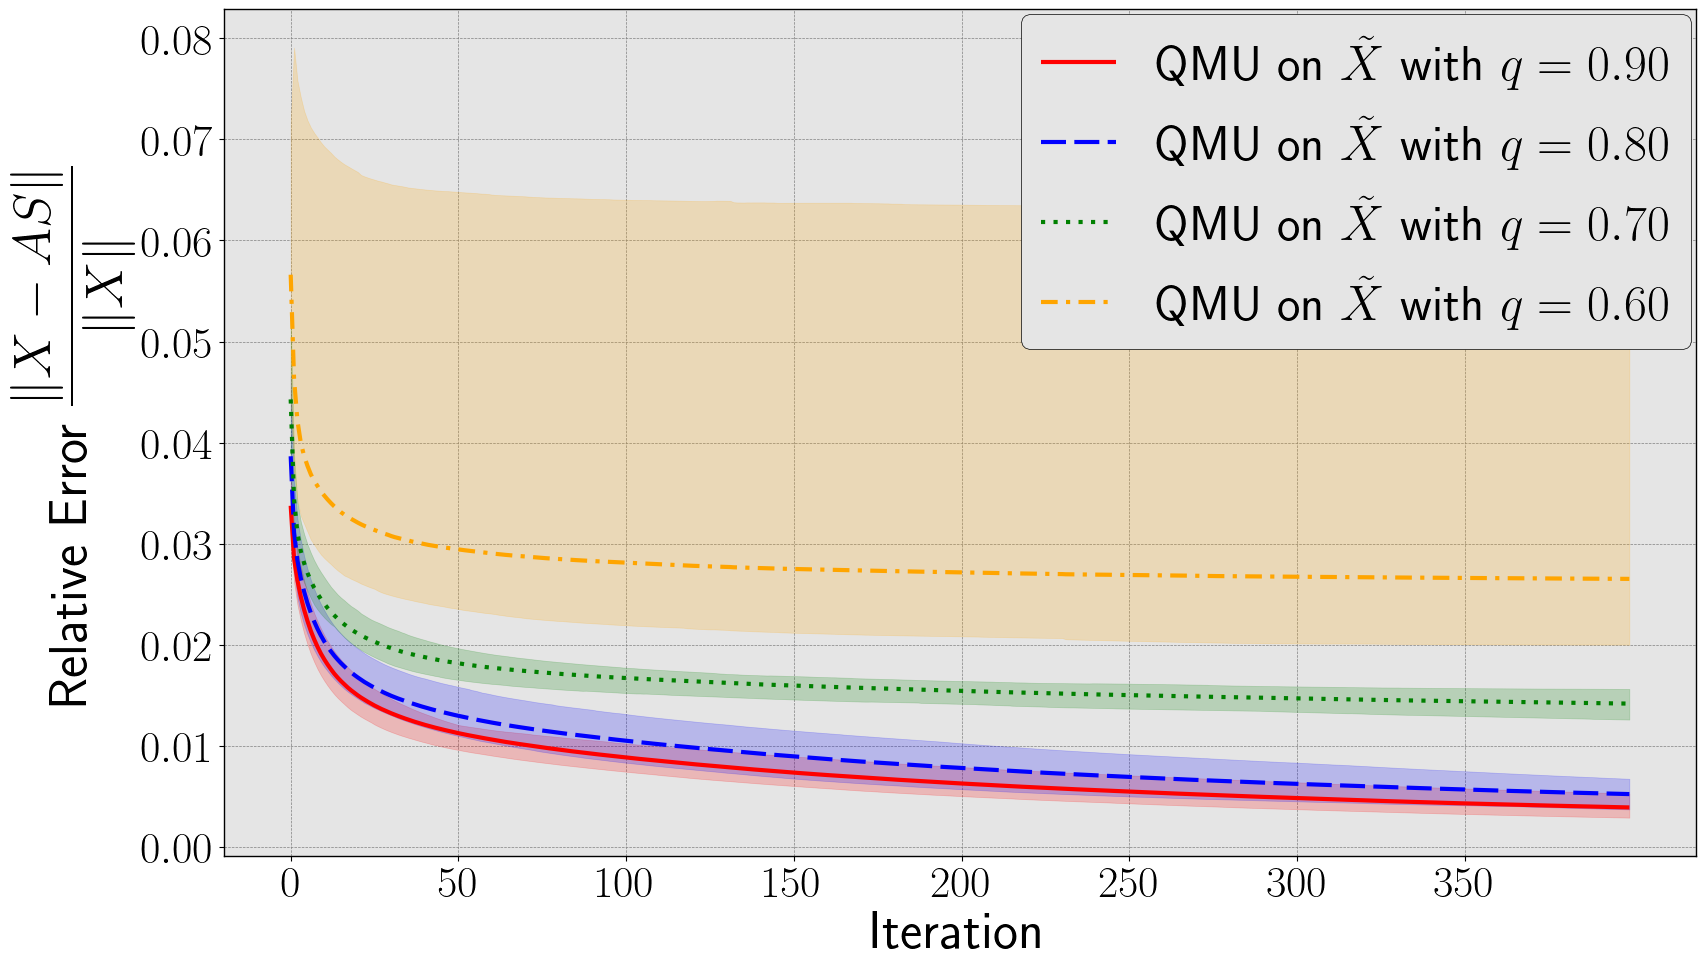

In [ ]:
error = {}
num_runs = 10  # Number of experimental runs
num_iterations = 400  # Assuming 400 iterations for each run (set this to match the actual number of iterations in errors)
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.90$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.80$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.70$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.60$"] = np.zeros((num_runs, num_iterations))

for i in range(num_runs):
    X, X_corrupted = generate_factorable_matrix(50, 40, 10, corruption_prop=0.1)

    _, _, _, errors = CorruptionRobustNMF(X, X, num_iterations, 10, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.90$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 10, .8)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.80$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 10, .7)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.70$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 10, .6)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle q = 0.60$"][i, :] = errors

plot_experiment_multiple_runs(error)

### Different Model Ranks

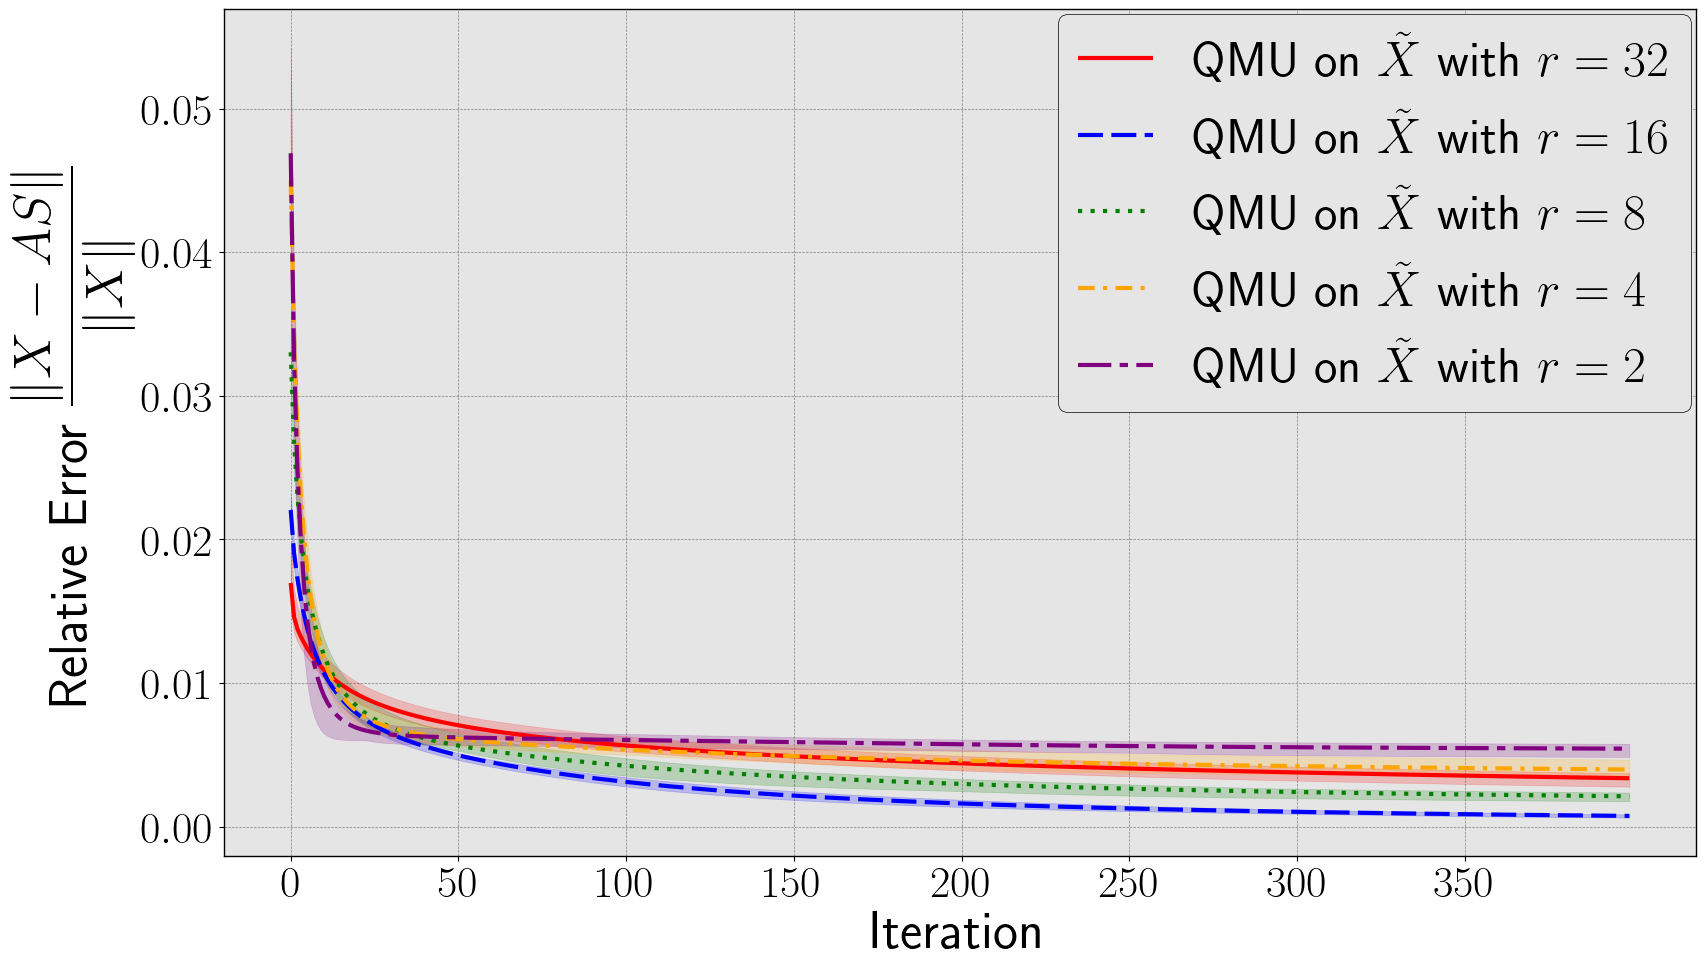

In [ ]:
error = {}
num_runs = 10  # Number of experimental runs
num_iterations = 400  # Assuming 400 iterations for each run (set this to match the actual number of iterations in errors)
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 32$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 16$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 8$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 4$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 2$"] = np.zeros((num_runs, num_iterations))

for i in range(num_runs):
    X, X_corrupted = generate_factorable_matrix(64, 48, 16, corruption_prop=0.1)

    _, _, _, errors = CorruptionRobustNMF(X, X, num_iterations, 32, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 32$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 16, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 16$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 8, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 8$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 4, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 4$"][i, :] = errors

    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 2, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle r = 2$"][i, :] = errors

plot_experiment_multiple_runs(error)

### Different Corruption Fractions

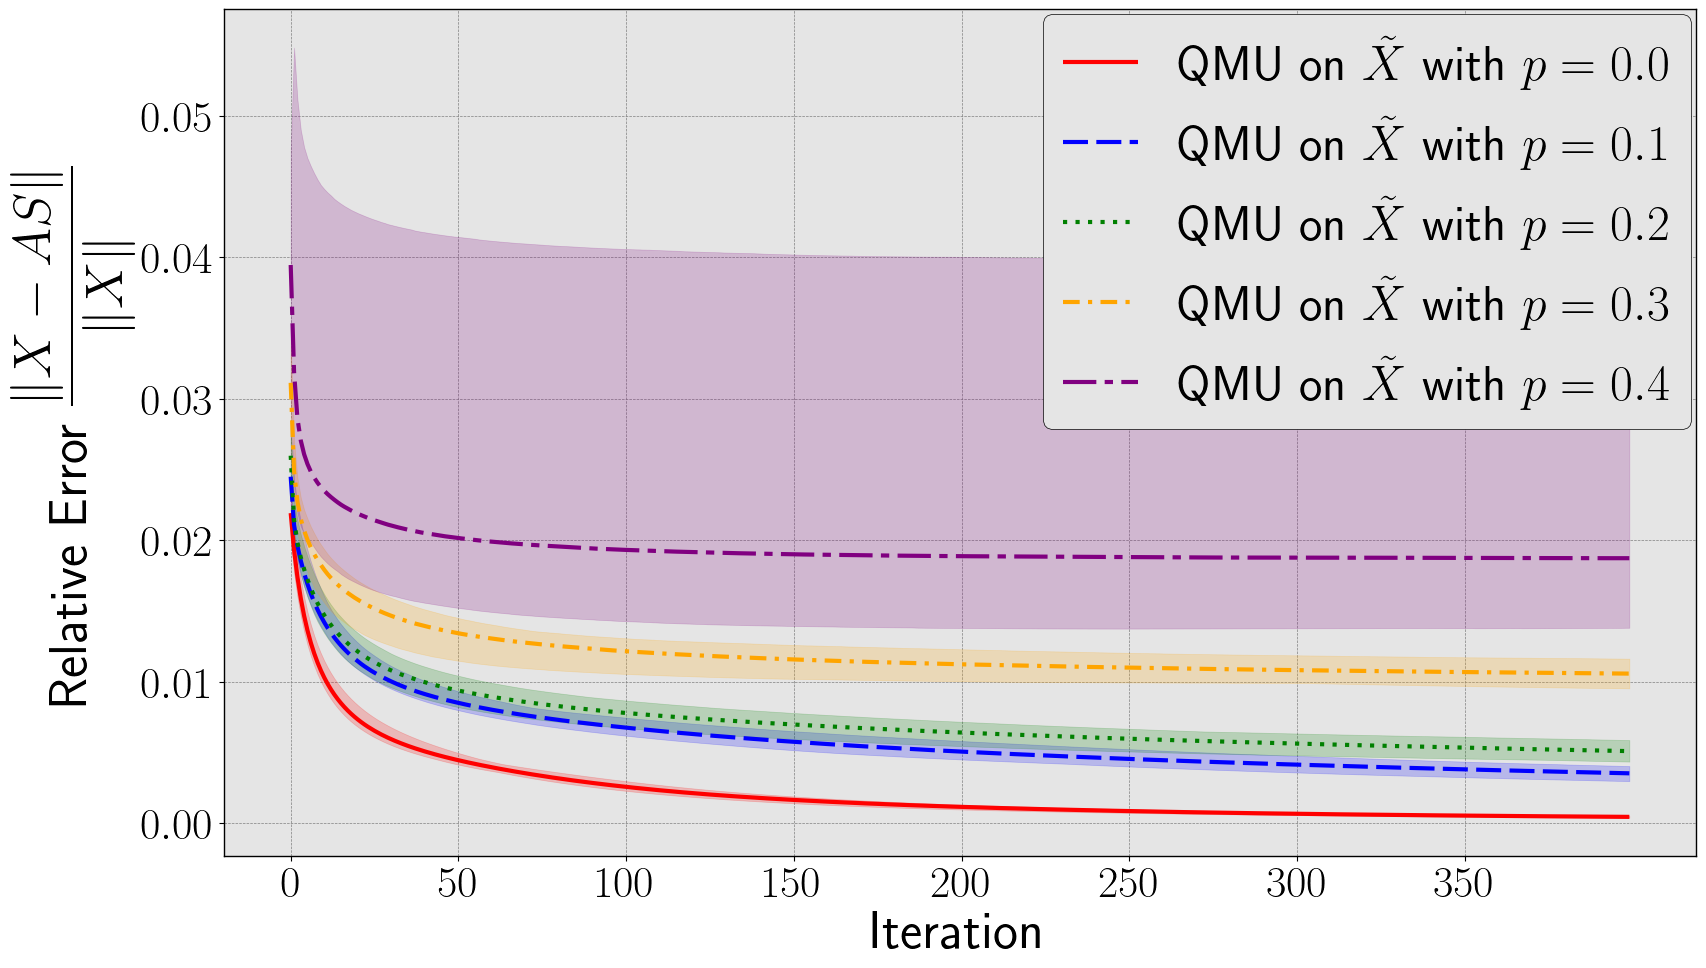

In [ ]:
error = {}
num_runs = 10  # Number of experimental runs
num_iterations = 400  # Assuming 400 iterations for each run (set this to match the actual number of iterations in errors)
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.0$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.1$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.2$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.3$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.4$"] = np.zeros((num_runs, num_iterations))

for i in range(num_runs):
    X, X_corrupted = generate_factorable_matrix(64, 48, 16, corruption_prop=0.0)
    _, _, _, errors = CorruptionRobustNMF(X, X, num_iterations, 16, 1.0)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.0$"][i, :] = errors

    X, X_corrupted = generate_factorable_matrix(64, 48, 16, corruption_prop=0.1)
    _, _, _, errors = CorruptionRobustNMF(X, X, num_iterations, 16, 0.9)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.1$"][i, :] = errors

    X, X_corrupted = generate_factorable_matrix(64, 48, 16, corruption_prop=0.2)
    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 16, .8)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.2$"][i, :] = errors

    X, X_corrupted = generate_factorable_matrix(64, 48, 16, corruption_prop=0.3)
    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 16, .7)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.3$"][i, :] = errors

    X, X_corrupted = generate_factorable_matrix(64, 48, 16, corruption_prop=0.4)
    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 16, .6)
    error[r"QMU on $\displaystyle \tilde{X}$ with $\displaystyle p = 0.4$"][i, :] = errors

plot_experiment_multiple_runs(error)

###Different Matrix Dimensions

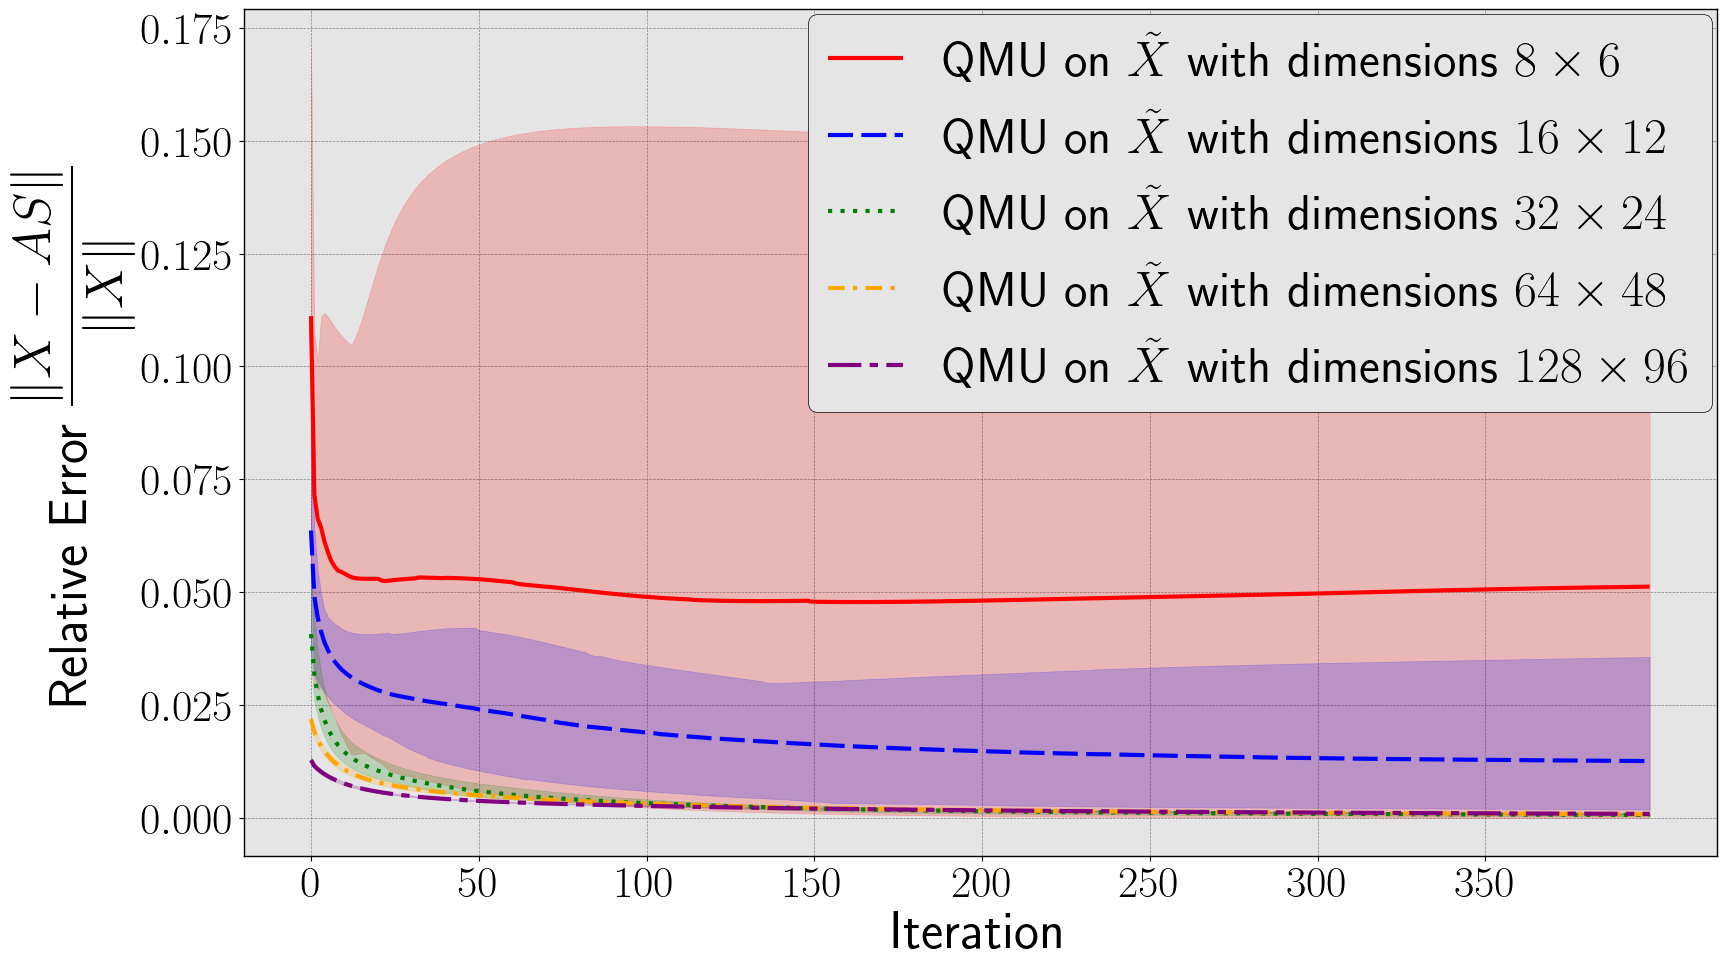

In [ ]:
error = {}
num_runs = 10  # Number of experimental runs
num_iterations = 400  # Assuming 400 iterations for each run (set this to match the actual number of iterations in errors)
error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 8 \times 6$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 16 \times 12$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 32 \times 24$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 64 \times 48$"] = np.zeros((num_runs, num_iterations))
error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 128 \times 96$"] = np.zeros((num_runs, num_iterations))

for i in range(num_runs):
    X, X_corrupted = generate_factorable_matrix(8, 6, 2, corruption_prop=0.1)
    _, _, _, errors = CorruptionRobustNMF(X, X, num_iterations, 2, 0.9)
    error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 8 \times 6$"][i, :] = errors

    X, X_corrupted = generate_factorable_matrix(16, 12, 4, corruption_prop=0.1)
    _, _, _, errors = CorruptionRobustNMF(X, X, num_iterations, 4, 0.9)
    error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 16 \times 12$"][i, :] = errors

    X, X_corrupted = generate_factorable_matrix(32, 24, 8, corruption_prop=0.1)
    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 8, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 32 \times 24$"][i, :] = errors

    X, X_corrupted = generate_factorable_matrix(64, 48, 16, corruption_prop=0.1)
    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 16, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 64 \times 48$"][i, :] = errors

    X, X_corrupted = generate_factorable_matrix(128, 96, 32, corruption_prop=0.1)
    _, _, _, errors = CorruptionRobustNMF(X, X_corrupted, 400, 32, .9)
    error[r"QMU on $\displaystyle \tilde{X}$ with dimensions $\displaystyle 128 \times 96$"][i, :] = errors

plot_experiment_multiple_runs(error)

Same plot, but with a log scale

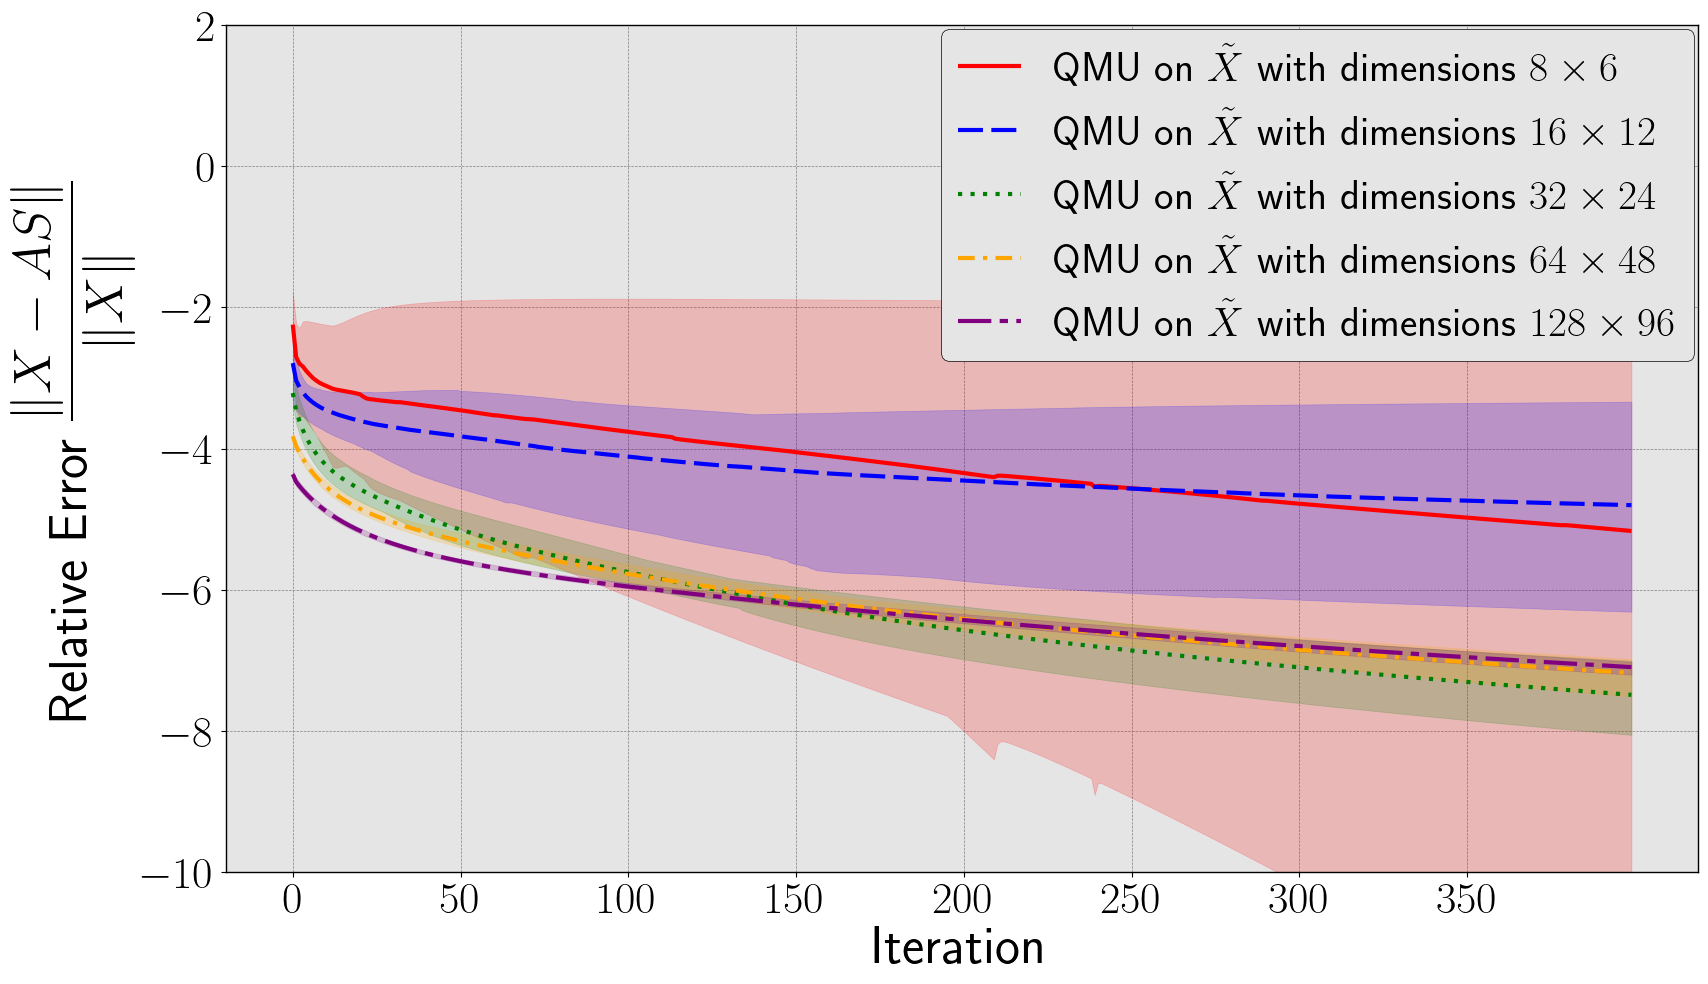

In [ ]:
def plot_experiment_multiple_runs_log_scale(errors):
    plt.style.use('ggplot')
    plt.rcParams["figure.figsize"] = (19, 11)
    plt.rcParams["font.size"] = 32
    plt.rcParams["xtick.color"] = 'black'
    plt.rcParams["ytick.color"] = 'black'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # for \text command

    LABELS = list(errors.keys())
    num_iterations = errors[LABELS[0]].shape[1]
    domain = range(num_iterations)
    DASHES = [
        [1, 0],  # Solid
        [6, 2],  # Dashed
        [1, 2],  # Dotted
        [4, 2, 1, 2],  # Dash-Dot
        [8, 2, 2, 2],  # Custom
    ]
    COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'teal', 'yellow', 'pink']

    plt.figure()

    for i, label in enumerate(LABELS):
        data_matrix = errors[label]

        # Calculate the mean, min, and max for each iteration across different runs
        mean_error = np.mean(data_matrix, axis=0)
        min_error = np.min(data_matrix, axis=0)
        max_error = np.max(data_matrix, axis=0)

        # Plot the mean error line
        plt.plot(domain, mean_error, label=label, color=COLORS[i], dashes=DASHES[i], linewidth=3)

        # Fill between min and max for error region
        plt.fill_between(domain, min_error, max_error, color=COLORS[i], alpha=0.2)

    plt.xlabel("Iteration", color='black')
    plt.ylabel(r"\text{Relative Error} $\displaystyle\frac{\lVert X - AS \rVert}{\lVert X \rVert}$", color='black')
    plt.ylim(-10, 2)
    plt.xticks(ticks=np.arange(0, num_iterations, step=max(1, num_iterations // 8)))
    plt.grid(color='grey', linestyle='--', linewidth=.5)
    plt.legend(fancybox=True, handlelength=1.5, shadow=False, loc='upper right', ncol=1, fontsize=30, framealpha=1.0, edgecolor='black', borderpad=0.4, borderaxespad=.1)
    plt.show()

log_error = {}
for run in error:
  log_error[run] = np.log(error[run])
plot_experiment_multiple_runs_log_scale(log_error)